In [1]:
!pip install numpy torch sympy mod blobfile pandas seaborn matplotlib tqdm einops wandb

import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from contextlib import suppress
from dataclasses import dataclass, asdict
from datetime import datetime
from typing import Callable, Literal, Optional, Union, Tuple, List
from copy import deepcopy

import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import optim
import wandb
from tqdm.notebook import tqdm
import ipywidgets as widgets
import wandb

import matplotlib as mpl
from matplotlib.colors import LogNorm
import seaborn as sns
import matplotlib.pyplot as plt

from patterns.dataset import ModularArithmetic, Operator
from patterns.transformer import Transformer
from patterns.utils import generate_run_name
from patterns.learner import Config

from toy_models.fit import rescale_run, Pattern, PatternLearningModel

from unifying.sweep import get_history, handle_outliers
from unifying.plotting import BLUE, RED

DEFAULT_MODULUS = 113
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sns.set_theme(style="darkgrid")


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
from contextlib import suppress
from copy import deepcopy
from dataclasses import asdict, dataclass
from datetime import datetime
from typing import Callable, List, Literal, Optional, Tuple, Union

import ipywidgets as widgets
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from matplotlib.colors import LogNorm
from torch import nn, optim
from tqdm.notebook import tqdm

import wandb


def rescale_run(run, new_max=1.0, log=True):
    # Changes the steps to fit in the range [0, 100] (following a log scale)
    run = run.copy()
    max_ = run["_step"].max()

    if log:
        max_ = np.log(max_)
        run["_step"] = np.log(run["_step"]) / max_ * new_max
    else:
        run["_step"] = run["_step"] / max_ * new_max

    return run


class Pattern(nn.Module):
    def __init__(self, max_time: float = 1.0, onset: Optional[float] = None, generalization: Optional[float] = None, strength: Optional[float] = None, speed: Optional[float] = None):
        # 4 scalar parameters: strength, speed, onset, generalization
        super().__init__()

        strength = strength or torch.rand(1)[0]
        speed = speed or torch.rand(1)[0] * 10 / max_time
        onset = onset or torch.rand(1)[0] * max_time
        generalization = generalization or torch.rand(1)[0]

        self._strength = nn.Parameter(self._inv_sigmoid(torch.tensor(strength)))
        self.speed = nn.Parameter(torch.tensor(speed))
        self.onset = nn.Parameter(torch.tensor(onset))
        self._generalization = nn.Parameter(torch.log(torch.tensor(generalization)))

    @staticmethod
    def _inv_sigmoid(x):
        return torch.log(x / (1 - x))
    
    @property
    def strength(self):
        return F.sigmoid(self._strength)
    
    @strength.setter
    def strength(self, value):
        self._strength = self._inv_sigmoid(value)

    @property
    def generalization(self):
        return torch.exp(self._generalization)
    
    @generalization.setter
    def generalization(self, value):
        self._generalization = torch.log(value)

    def forward(self, t):
        return self.strength * F.sigmoid(self.speed * (t - self.onset))

    def __repr__(self):
        return f"Pattern(strength={self.strength.data.float()}, speed={self.speed.data.float()}, onset={self.onset.data.float()}, generalization={self.generalization.data.float()})"


class PatternLearningModel(nn.Module):
    def __init__(self, num_patterns: int = 3, max_time=1.0):
        super().__init__()
        self.num_patterns = num_patterns
        self.patterns = nn.ModuleList([
            Pattern(
                max_time, 
                onset=max_time * (i + 1) / (num_patterns + 1),
                speed=10./max_time,
                generalization=0.5,
                strength=0.5
            ) 
            for i in range(num_patterns)
        ])
        self.max_time = max_time

        self.binary_mask = torch.tensor(
            [
                [int(i) for i in bin(j)[2:].zfill(num_patterns)]
                for j in range(2**num_patterns)
            ]
        ).float()

        self.counts = self.binary_mask.sum(dim=1)

    def forward(self, t):
        return 1 - torch.prod(1 - self.predictivenesses(t), dim=0)

    # def usages(self, t):
    #     preds = self.predictivenesses(t)
    #     usages = torch.prod(preds.T * self.binary_mask + (1 - preds.T) * (1 - self.binary_mask), dim=1)
    #     return usages

    def gs(self):
        return torch.stack([p.generalization for p in self.patterns])

    # def generalizations(self):
    #     generalizations = torch.sum(self.gs().T * self.binary_mask, dim=1) / self.counts
    #     generalizations[0] = 0
    #     return generalizations

    def predictivenesses(self, t):
        return torch.stack([p(t) for p in self.patterns])

    def forward(self, t):
        prod = 1

        for p in self.patterns:
            prod *= 1 - p(t)

        return 1 - prod

    def usages(self, t):
        preds = [p(t) for p in self.patterns]
        usages = torch.ones(2**self.num_patterns)

        for i in range(2**self.num_patterns):
            for j in range(self.num_patterns):
                if i & (1 << j):
                    usages[i] *= preds[j]
                else:
                    usages[i] *= 1 - preds[j]

        return usages

    def generalizations(self):
        generalizations = torch.zeros(2**self.num_patterns)

        for i in range(2**self.num_patterns):
            count = 0
            total = 0

            for j in range(self.num_patterns):
                if i & (1 << j):
                    # print(i, j, self.patterns[j].generalization, generalizations[i])
                    generalizations[i] += self.patterns[j].generalization
                    count += 1
                
                total += self.patterns[j].generalization

            # if count > 0:
            #     generalizations[i] /= count

            if total > 0:
                generalizations[i] /= total

        return generalizations

    def test(self, t):
        return torch.sum(self.generalizations() * self.usages(t), dim=0)

    def fit(self, run, lr=0.1, num_epochs=1000, callback=None, callback_ivl=100):
        ts = torch.tensor(run._step.values).float()

        train_ys = torch.tensor(run["train/acc"].values).float()
        test_ys = torch.tensor(run["test/acc"].values).float()

        optimizer = optim.Adam(self.parameters(), lr=lr)
        criterion = nn.MSELoss()
        # Cross-entropy
        eps = 1e-6
        # criterion = lambda preds, ys: -torch.sum(ys * torch.log(preds + eps) + (1 - ys) * torch.log(1 - preds + eps))
        callback(self)

        for epoch in tqdm(range(num_epochs)):
            train_preds = torch.zeros_like(train_ys)
            test_preds = torch.zeros_like(test_ys)

            optimizer.zero_grad()

            for i, t in enumerate(ts):
                train_preds[i] = self(t)
                test_preds[i] = self.test(t)

            loss = criterion(train_preds, train_ys) + criterion(test_preds, test_ys)
            loss.backward()
            optimizer.step()

            print(f"Epoch {epoch} - loss: {loss.item()}")
            
            if callback is not None and epoch % callback_ivl == 0:
                callback(self)

        return self

    def to_dict(self):
        """To a dataframe, sorting patterns by onset time"""
        patterns = sorted(self.patterns, key=lambda p: p.onset.data)
        d = {}

        for i, p in enumerate(patterns):
            d[f"pattern_{i}/strength"] = p.strength.data
            d[f"pattern_{i}/speed"] = p.speed.data
            d[f"pattern_{i}/onset"] = p.onset.data
            d[f"pattern_{i}/generalization"] = p.generalization.data

        return d
    
    def rescale(self, max_time):
        """Rescale the model to a new max time"""
        scaling_factor = max_time / self.max_time

        for p in self.patterns:
            p.onset.data /= scaling_factor
            p.speed.data *= scaling_factor

        self.max_time = max_time

    def __repr__(self):
        return f"PatternLearningModel({self.to_dict()})"


In [3]:
torch.manual_seed(2)
pl_model = PatternLearningModel(max_time=100.)

def plot_patterns(pl_model, run):
    ts = run["_step"].values
    train_preds = [pl_model(t).detach().numpy() for t in ts]
    test_preds = [pl_model.test(t).detach().numpy() for t in ts]
    train_ys = torch.tensor(run["train/acc"].values).float()
    test_ys = torch.tensor(run["test/acc"].values).float()
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].plot(ts, train_preds, label="train", color="blue")
    axes[0].plot(ts, test_preds, label="test", color="red")

    axes[1].plot(ts, train_ys, label="train", color="blue")
    axes[1].plot(ts, test_ys, label="test", color="red")

    axes[0].set_title("Predictions")
    axes[1].set_title("True values")

    # axes[0].set_xscale("log")
    # axes[1].set_xscale("log")


In [4]:
def _plot_patterns(pl_model):
    plot_patterns(pl_model, rescaled_run)
    plt.show()

    print(pl_model.patterns)


pl_model = PatternLearningModel(num_patterns=3, max_time=100.)
# pl_model.fit(rescaled_run, lr=0.1, callback=_plot_patterns, callback_ivl=10, num_epochs=500)

In [5]:
VARIABLE_COLS = [
    "test/acc",
    "train/acc",
    "test/loss",
    "train/loss",
    "_step",
    "weight/norm",
    "test/efficiency",
    "train/efficiency",
    "weight/dist_from_init",
    "weight/cos_sim_with_init",
]

def fit_sweep(df: pd.DataFrame, unique_col: str, lr=0.1, max_time=1.0, num_patterns=3, num_epochs=500, **kwargs):
    unique_vals = df.loc[:, unique_col].unique()

    variable_cols = [c for c in df.columns if c in VARIABLE_COLS]
    hyperparams: dict = (
        df.loc[0, :]
        .drop(columns=[unique_col, *variable_cols])
        .to_dict()
    )

    wandb.init(
        project="fit-toy-model",
    )

    try:
        for unique_val in tqdm(unique_vals):
            run = df.loc[df[unique_col] == unique_val]
            rescaled_run = rescale_run(run, new_max=max_time)

            pl_model = PatternLearningModel(
                num_patterns=num_patterns, 
                max_time=max_time
            )

            def _plot_patterns(pl_model):
                plot_patterns(pl_model, rescaled_run)
                plt.show()

            pl_model.fit(rescaled_run, lr=lr, num_epochs=num_epochs, callback=_plot_patterns)
            pl_model.rescale(1.)

            wandb.log({unique_col: unique_val, **pl_model.to_dict(), **hyperparams, **kwargs})

            _plot_patterns(pl_model)
            plt.show()

    except KeyboardInterrupt:
        wandb.finish()


# Fit the sweeps

In [6]:
WD_SWEEP_ID = "ib21hnk1"
LN_SWEEP_ID = "8783j1j4"
DM_SWEEP_ID = "l1b2mmci"

dm_sweep_2 = pd.read_csv("../unifying/mw_sweep.csv")

SWEEP_IDS = ["mw-xander"] # [WD_SWEEP_ID, LN_SWEEP_ID, DM_SWEEP_ID]
UNIQUE_COLS = ["d_model"] # ["weight_decay", "frac_label_noise", "d_model"]
SWEEPS = [dm_sweep_2] # [get_history(sweep_id, unique_cols=unique_col) for sweep_id, unique_col in zip(SWEEP_IDS, UNIQUE_COLS)]

In [7]:
dm_sweep_2.fillna(method="ffill", inplace=True)
dm_sweep_2.loc[0, :].to_dict()

{'train/acc': 0.00390625,
 'test/acc': 0.0079467352479696,
 'train/loss': 7.533011436462402,
 'test/loss': 7.525015830993652,
 '_step': 172.0,
 'd_model': 1.0}

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jqhoogland. Use `wandb login --relogin` to force relogin


  0%|          | 0/76 [00:00<?, ?it/s]

/home/paperspace/Projects/quanta-learning/.venv/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


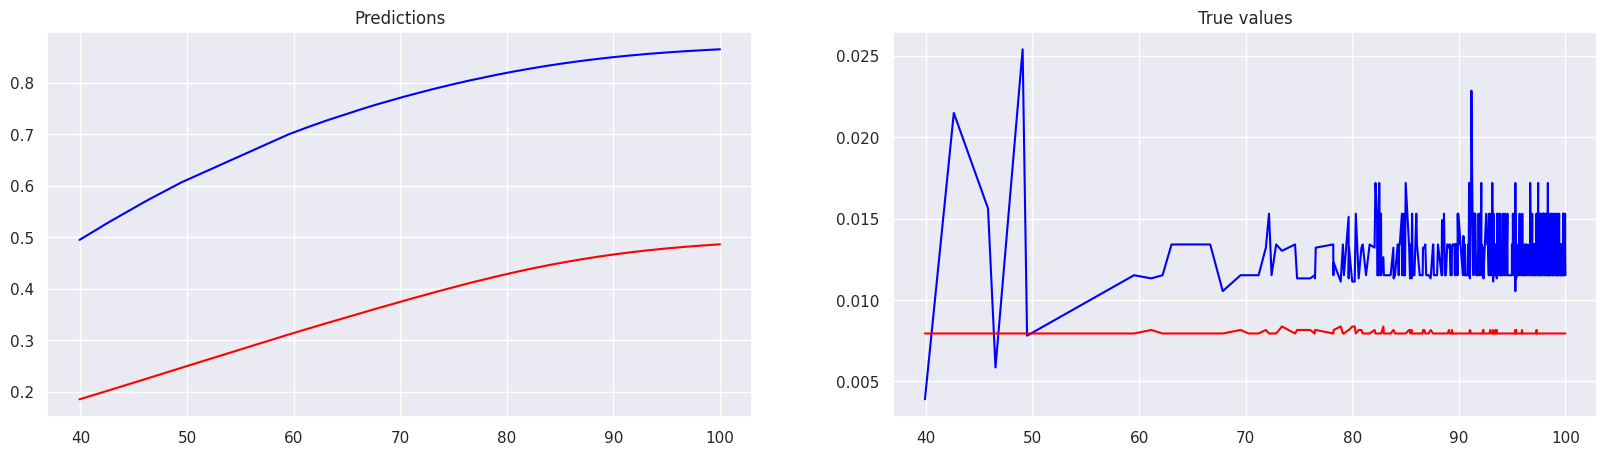

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0 - loss: 0.90924471616745


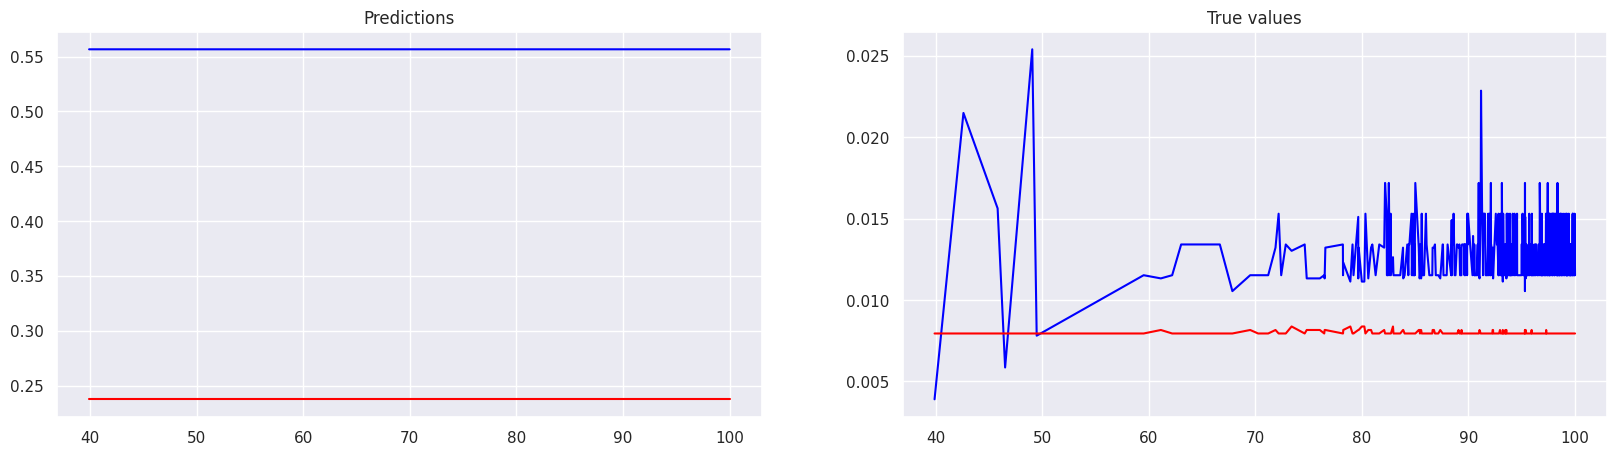

Epoch 1 - loss: 0.34863367676734924
Epoch 2 - loss: 0.01879708655178547
Epoch 3 - loss: 0.011025755666196346
Epoch 4 - loss: 0.009946267120540142
Epoch 5 - loss: 0.00943095050752163
Epoch 6 - loss: 0.009030604735016823
Epoch 7 - loss: 0.00866723246872425
Epoch 8 - loss: 0.008322208188474178
Epoch 9 - loss: 0.007990965619683266
Epoch 10 - loss: 0.0076727126725018024
Epoch 11 - loss: 0.0073676081374287605
Epoch 12 - loss: 0.007075919769704342
Epoch 13 - loss: 0.006797758396714926
Epoch 14 - loss: 0.006533063482493162
Epoch 15 - loss: 0.006281610578298569
Epoch 16 - loss: 0.006043050903826952
Epoch 17 - loss: 0.00581694021821022
Epoch 18 - loss: 0.005602769088000059
Epoch 19 - loss: 0.0053999898955225945
Epoch 20 - loss: 0.0052080354653298855
Epoch 21 - loss: 0.005026332102715969
Epoch 22 - loss: 0.004854302387684584
Epoch 23 - loss: 0.00469138752669096
Epoch 24 - loss: 0.004537039902061224
Epoch 25 - loss: 0.0043907384388148785
Epoch 26 - loss: 0.0042519778944551945
Epoch 27 - loss: 0.00

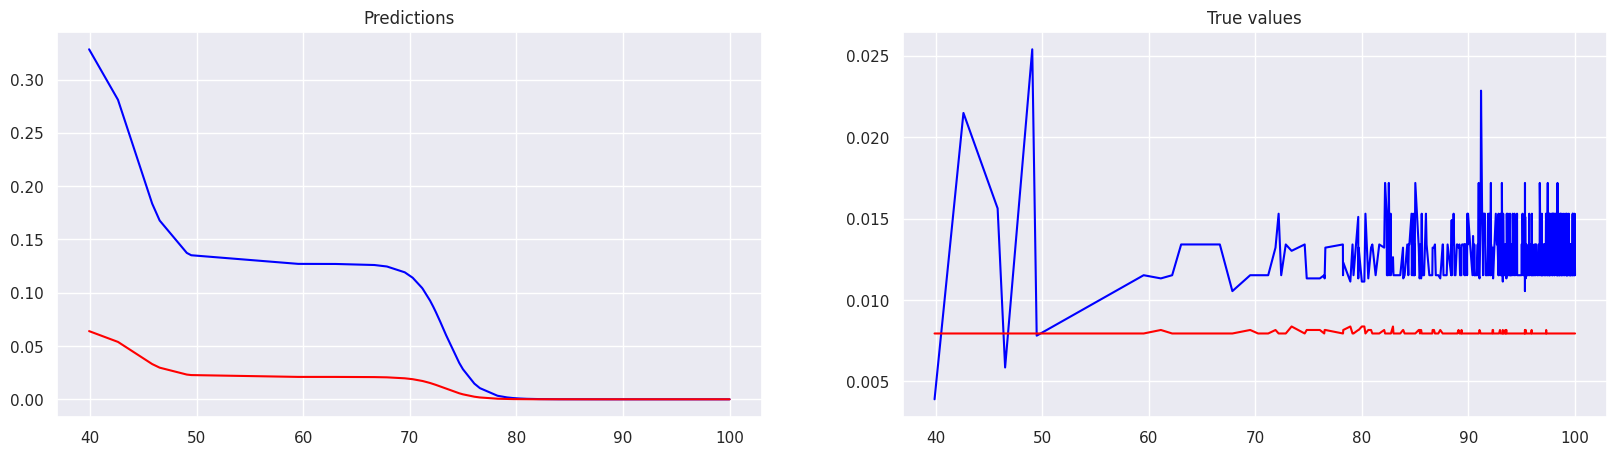

Epoch 101 - loss: 0.0010243705473840237
Epoch 102 - loss: 0.0010123044485226274
Epoch 103 - loss: 0.0010004881769418716
Epoch 104 - loss: 0.0009889136999845505
Epoch 105 - loss: 0.0009775747312232852
Epoch 106 - loss: 0.0009664632380008698
Epoch 107 - loss: 0.000955573283135891
Epoch 108 - loss: 0.0009448981727473438
Epoch 109 - loss: 0.0009344315039925277
Epoch 110 - loss: 0.0009241676307283342
Epoch 111 - loss: 0.00091410061577335
Epoch 112 - loss: 0.0009042251040227711
Epoch 113 - loss: 0.000894535391125828
Epoch 114 - loss: 0.0008850271115079522
Epoch 115 - loss: 0.0008756950264796615
Epoch 116 - loss: 0.0008665346540510654
Epoch 117 - loss: 0.0008575408137403429
Epoch 118 - loss: 0.000848709954880178
Epoch 119 - loss: 0.0008400373626500368
Epoch 120 - loss: 0.0008315190207213163
Epoch 121 - loss: 0.0008231517276726663
Epoch 122 - loss: 0.0008149307104758918
Epoch 123 - loss: 0.0008068523602560163
Epoch 124 - loss: 0.0007989142904989421
Epoch 125 - loss: 0.0007911121938377619
Epoch

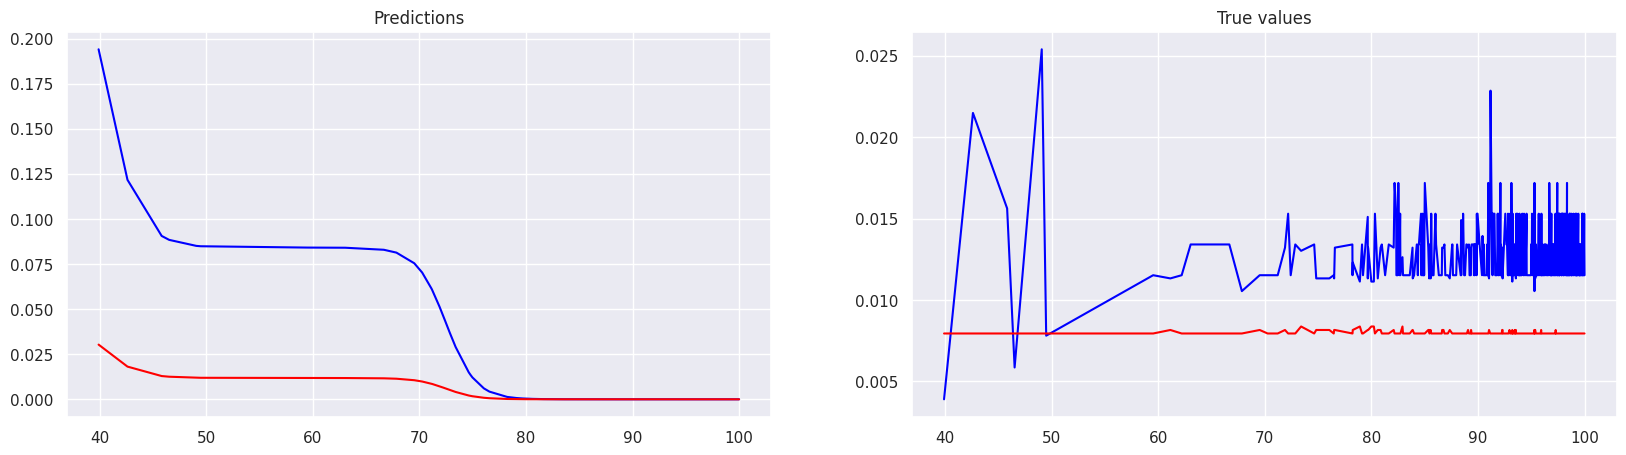

Epoch 201 - loss: 0.0004477566108107567
Epoch 202 - loss: 0.0004453514702618122
Epoch 203 - loss: 0.00044298218563199043
Epoch 204 - loss: 0.00044064802932552993
Epoch 205 - loss: 0.0004383485938888043
Epoch 206 - loss: 0.0004360831808298826
Epoch 207 - loss: 0.00043385144090279937
Epoch 208 - loss: 0.0004316529957577586
Epoch 209 - loss: 0.0004294870013836771
Epoch 210 - loss: 0.0004273530503269285
Epoch 211 - loss: 0.0004252510261721909
Epoch 212 - loss: 0.0004231802304275334
Epoch 213 - loss: 0.0004211397026665509
Epoch 214 - loss: 0.00041912973392754793
Epoch 215 - loss: 0.00041714945109561086
Epoch 216 - loss: 0.0004151985631324351
Epoch 217 - loss: 0.0004132764879614115
Epoch 218 - loss: 0.0004113825270906091
Epoch 219 - loss: 0.0004095166805200279
Epoch 220 - loss: 0.0004076783370692283
Epoch 221 - loss: 0.00040586668183095753
Epoch 222 - loss: 0.0004040819185320288
Epoch 223 - loss: 0.0004023232322651893
Epoch 224 - loss: 0.00040059027378447354
Epoch 225 - loss: 0.0003988827229

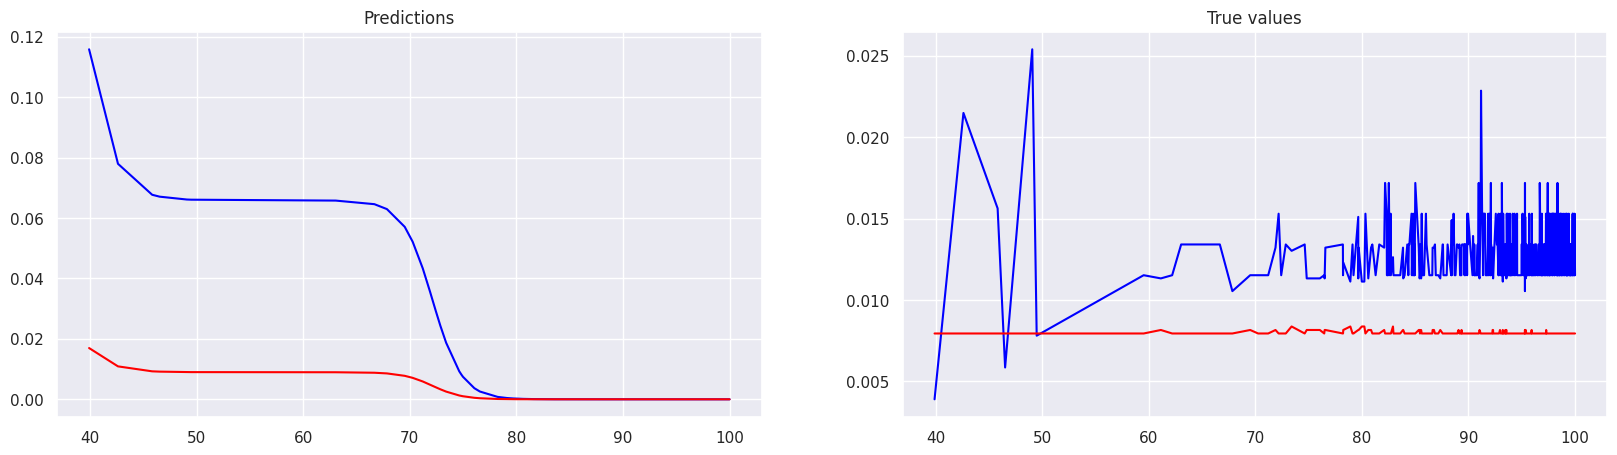

Epoch 301 - loss: 0.0003185548121109605
Epoch 302 - loss: 0.00031791545916348696
Epoch 303 - loss: 0.0003172828583046794
Epoch 304 - loss: 0.0003166568640153855
Epoch 305 - loss: 0.00031603724346496165
Epoch 306 - loss: 0.0003154242585878819
Epoch 307 - loss: 0.00031481756013818085
Epoch 308 - loss: 0.00031421706080436707
Epoch 309 - loss: 0.00031362264417111874
Epoch 310 - loss: 0.0003130343684460968
Epoch 311 - loss: 0.00031245200079865754
Epoch 312 - loss: 0.00031187551212497056
Epoch 313 - loss: 0.00031130475690588355
Epoch 314 - loss: 0.00031073979334905744
Epoch 315 - loss: 0.00031018038862384856
Epoch 316 - loss: 0.00030962657183408737
Epoch 317 - loss: 0.00030907822656445205
Epoch 318 - loss: 0.00030853517819195986
Epoch 319 - loss: 0.0003079975431319326
Epoch 320 - loss: 0.0003074650012422353
Epoch 321 - loss: 0.00030693772714585066
Epoch 322 - loss: 0.0003064155753236264
Epoch 323 - loss: 0.00030589840025641024
Epoch 324 - loss: 0.0003053861146327108
Epoch 325 - loss: 0.00030

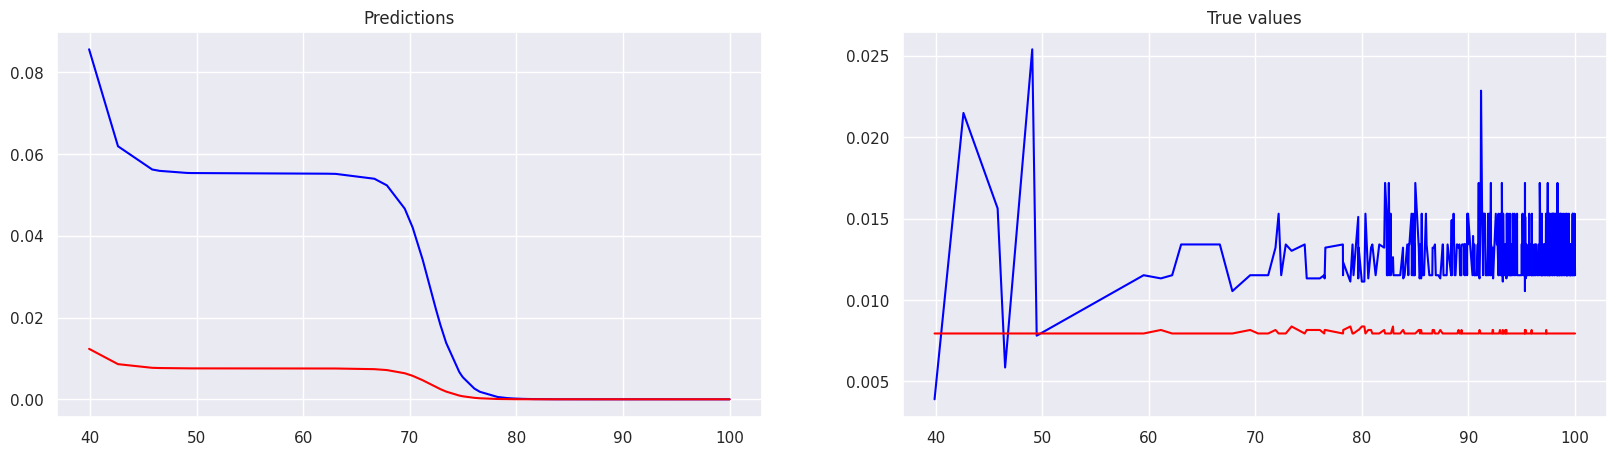

Epoch 401 - loss: 0.00027676107129082084
Epoch 402 - loss: 0.0002764919772744179
Epoch 403 - loss: 0.00027622480411082506
Epoch 404 - loss: 0.0002759594935923815
Epoch 405 - loss: 0.0002756961330305785
Epoch 406 - loss: 0.0002754346060100943
Epoch 407 - loss: 0.0002751748834270984
Epoch 408 - loss: 0.0002749170525930822
Epoch 409 - loss: 0.00027466105530038476
Epoch 410 - loss: 0.0002744067751336843
Epoch 411 - loss: 0.0002741542994044721
Epoch 412 - loss: 0.00027390356990508735
Epoch 413 - loss: 0.00027365461573936045
Epoch 414 - loss: 0.00027340734959580004
Epoch 415 - loss: 0.00027316182968206704
Epoch 416 - loss: 0.00027291796868667006
Epoch 417 - loss: 0.0002726757666096091
Epoch 418 - loss: 0.0002724352234508842
Epoch 419 - loss: 0.0002721964556258172
Epoch 420 - loss: 0.00027195923030376434
Epoch 421 - loss: 0.0002717235474847257
Epoch 422 - loss: 0.0002714895526878536
Epoch 423 - loss: 0.0002712571294978261
Epoch 424 - loss: 0.0002710262197069824
Epoch 425 - loss: 0.00027079693

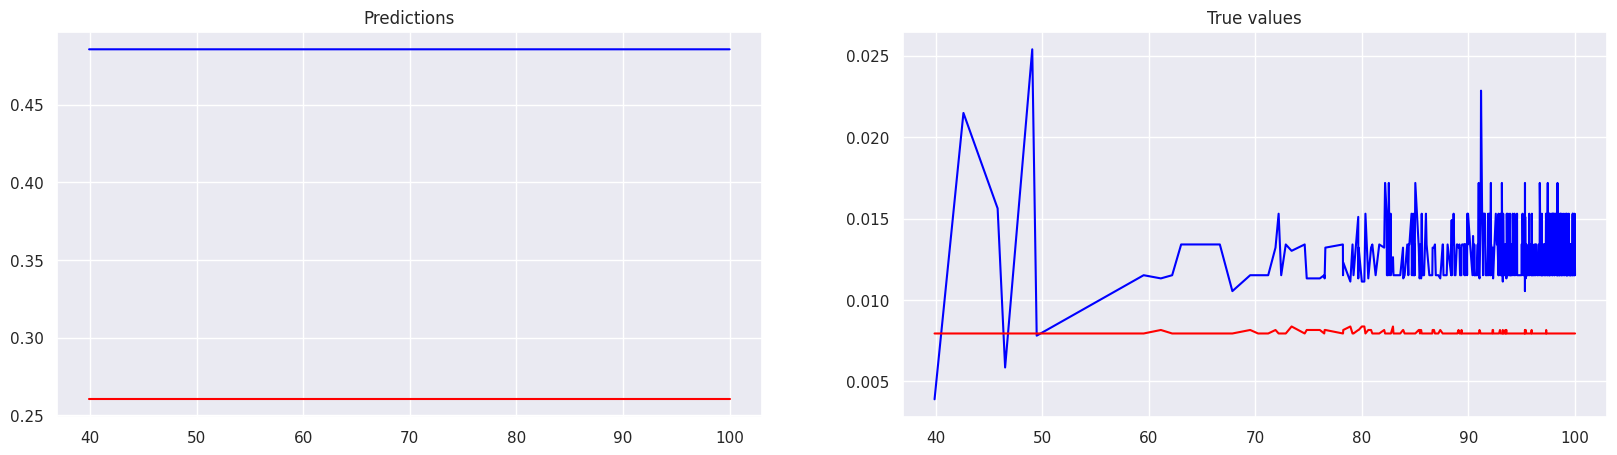

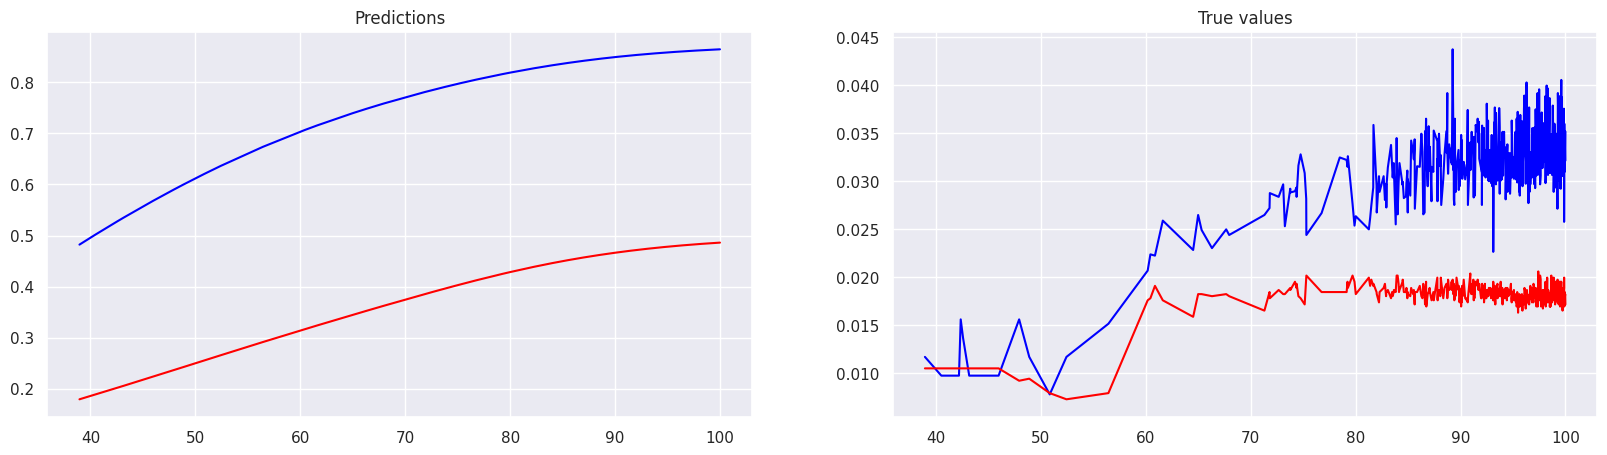

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0 - loss: 0.8591257333755493


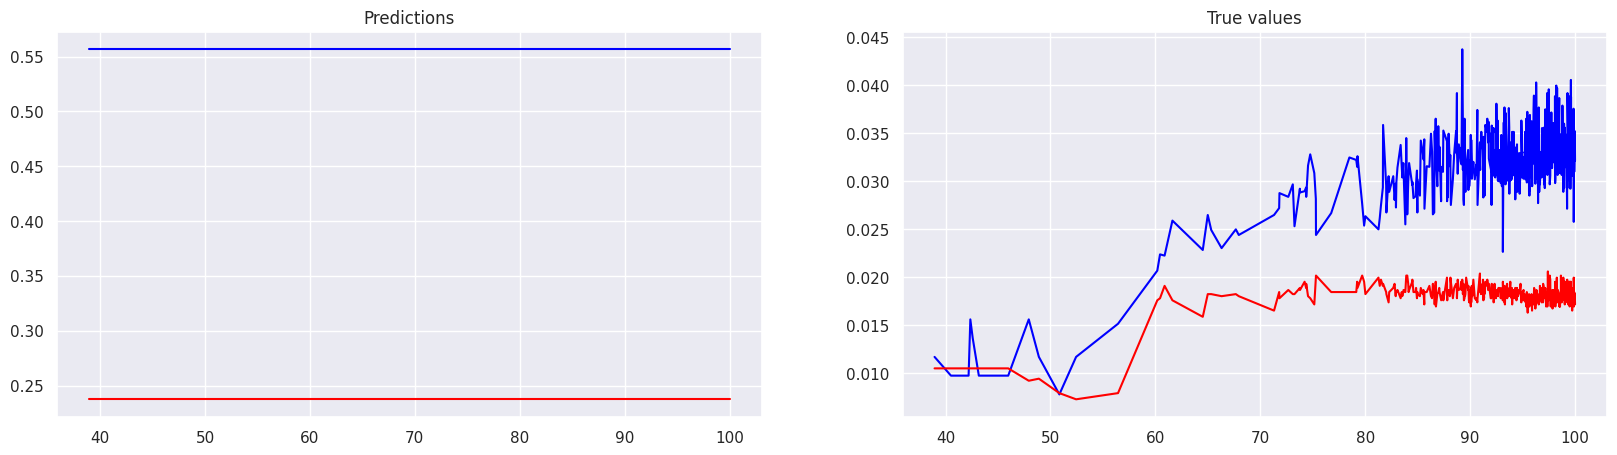

Epoch 1 - loss: 0.32365378737449646
Epoch 2 - loss: 0.021438447758555412
Epoch 3 - loss: 0.016307223588228226
Epoch 4 - loss: 0.015633929520845413
Epoch 5 - loss: 0.015085850842297077
Epoch 6 - loss: 0.014513857662677765
Epoch 7 - loss: 0.013927899301052094
Epoch 8 - loss: 0.013343196362257004
Epoch 9 - loss: 0.012770378962159157
Epoch 10 - loss: 0.012216152623295784
Epoch 11 - loss: 0.011684565804898739
Epoch 12 - loss: 0.011177897453308105
Epoch 13 - loss: 0.010697249323129654
Epoch 14 - loss: 0.010242905467748642
Epoch 15 - loss: 0.009814603254199028
Epoch 16 - loss: 0.009411699138581753
Epoch 17 - loss: 0.00903327763080597
Epoch 18 - loss: 0.008678270503878593
Epoch 19 - loss: 0.008345494046807289
Epoch 20 - loss: 0.00803371798247099
Epoch 21 - loss: 0.007741684094071388
Epoch 22 - loss: 0.007468154188245535
Epoch 23 - loss: 0.0072119105607271194
Epoch 24 - loss: 0.006971783470362425
Epoch 25 - loss: 0.006746653001755476
Epoch 26 - loss: 0.006535462569445372
Epoch 27 - loss: 0.0063

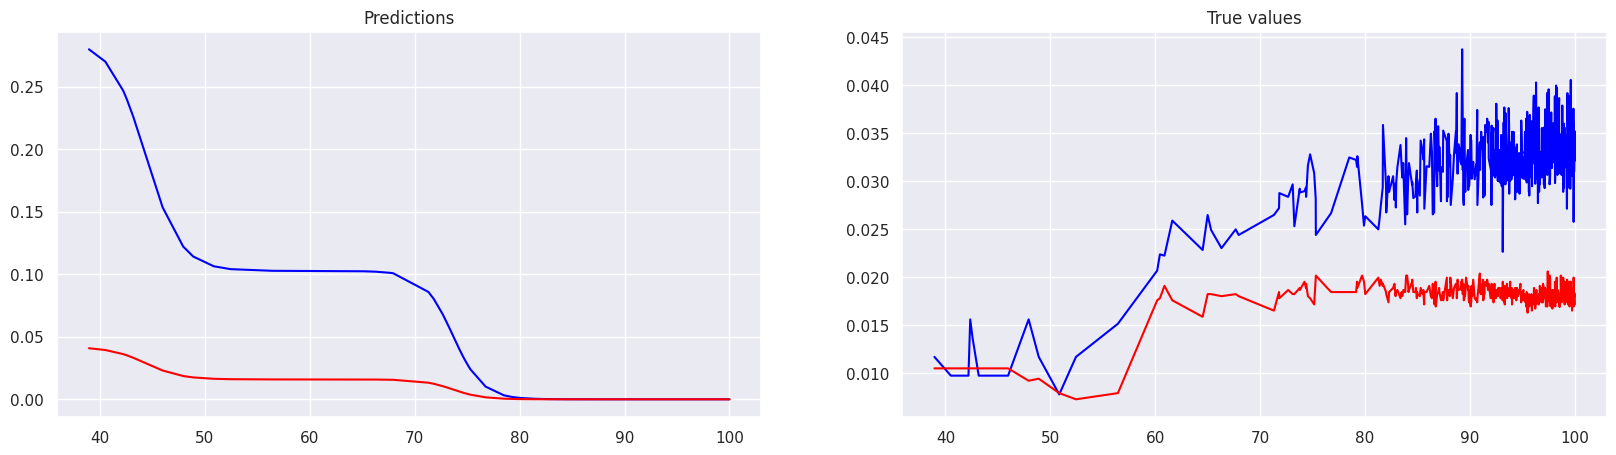

Epoch 101 - loss: 0.0022900619078427553
Epoch 102 - loss: 0.002273454563692212
Epoch 103 - loss: 0.002257110783830285
Epoch 104 - loss: 0.0022410245146602392
Epoch 105 - loss: 0.002225190633907914
Epoch 106 - loss: 0.0022096028551459312
Epoch 107 - loss: 0.0021942579187452793
Epoch 108 - loss: 0.002179150702431798
Epoch 109 - loss: 0.002164275385439396
Epoch 110 - loss: 0.0021496303379535675
Epoch 111 - loss: 0.0021352104377001524
Epoch 112 - loss: 0.0021210135892033577
Epoch 113 - loss: 0.0021070356015115976
Epoch 114 - loss: 0.0020932743791490793
Epoch 115 - loss: 0.002079726429656148
Epoch 116 - loss: 0.002066390821710229
Epoch 117 - loss: 0.00205326359719038
Epoch 118 - loss: 0.0020403440576046705
Epoch 119 - loss: 0.00202762964181602
Epoch 120 - loss: 0.002015119418501854
Epoch 121 - loss: 0.002002810826525092
Epoch 122 - loss: 0.0019907038658857346
Epoch 123 - loss: 0.0019787955097854137
Epoch 124 - loss: 0.001967085525393486
Epoch 125 - loss: 0.001955572050064802
Epoch 126 - los

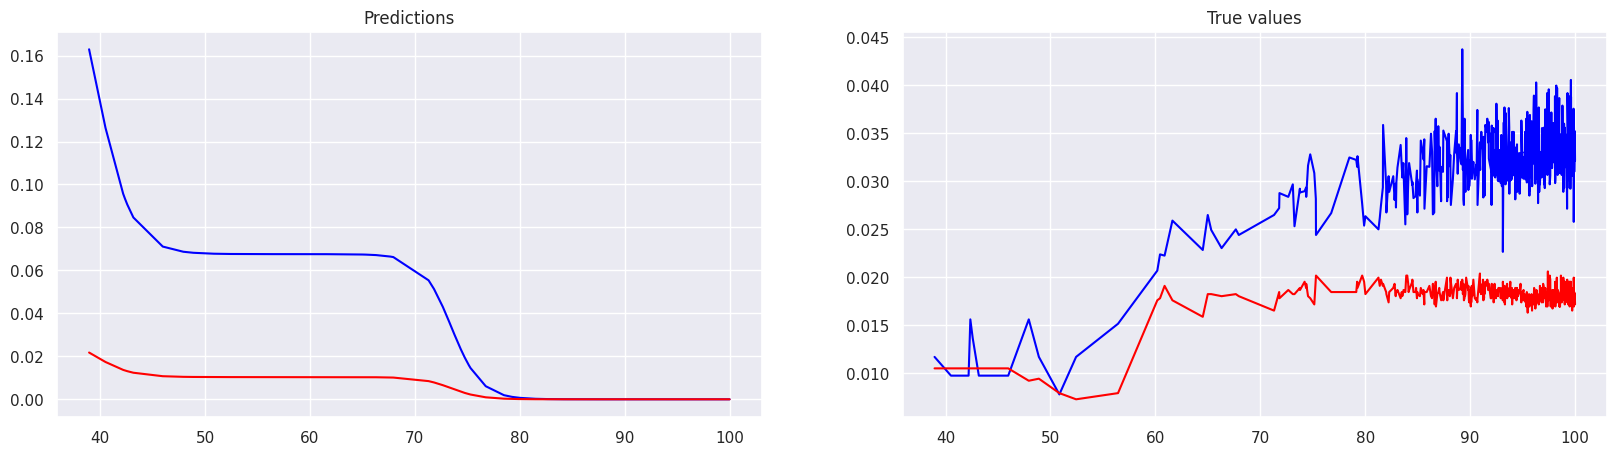

Epoch 201 - loss: 0.001513116993010044
Epoch 202 - loss: 0.0015107898507267237
Epoch 203 - loss: 0.0015085071790963411
Epoch 204 - loss: 0.001506267348304391
Epoch 205 - loss: 0.001504069659858942
Epoch 206 - loss: 0.0015019131824374199
Epoch 207 - loss: 0.0014997965190559626
Epoch 208 - loss: 0.0014977192040532827
Epoch 209 - loss: 0.0014956798404455185
Epoch 210 - loss: 0.0014936778461560607
Epoch 211 - loss: 0.001491712057031691
Epoch 212 - loss: 0.001489782240241766
Epoch 213 - loss: 0.001487886649556458
Epoch 214 - loss: 0.0014860250521451235
Epoch 215 - loss: 0.0014841962838545442
Epoch 216 - loss: 0.0014823998790234327
Epoch 217 - loss: 0.0014806349063292146
Epoch 218 - loss: 0.001478900550864637
Epoch 219 - loss: 0.0014771966962143779
Epoch 220 - loss: 0.0014755215961486101
Epoch 221 - loss: 0.0014738752506673336
Epoch 222 - loss: 0.0014722573105245829
Epoch 223 - loss: 0.001470666378736496
Epoch 224 - loss: 0.0014691019896417856
Epoch 225 - loss: 0.0014675641432404518
Epoch 22

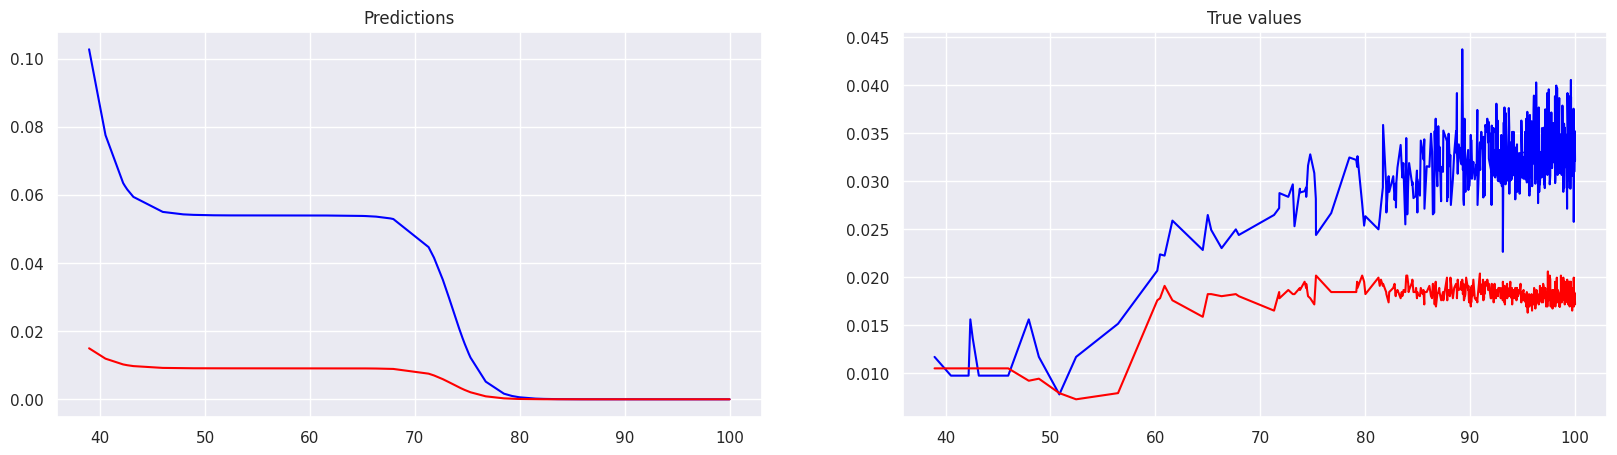

Epoch 301 - loss: 0.0013976338086649776
Epoch 302 - loss: 0.0013970878208056092
Epoch 303 - loss: 0.001396547886542976
Epoch 304 - loss: 0.0013960134238004684
Epoch 305 - loss: 0.0013954846654087305
Epoch 306 - loss: 0.0013949613785371184
Epoch 307 - loss: 0.001394443679600954
Epoch 308 - loss: 0.0013939312193542719
Epoch 309 - loss: 0.0013934241142123938
Epoch 310 - loss: 0.001392922131344676
Epoch 311 - loss: 0.0013924251543357968
Epoch 312 - loss: 0.0013919334160163999
Epoch 313 - loss: 0.0013914467999711633
Epoch 314 - loss: 0.001390964724123478
Epoch 315 - loss: 0.0013904878869652748
Epoch 316 - loss: 0.0013900154735893011
Epoch 317 - loss: 0.0013895478332415223
Epoch 318 - loss: 0.0013890848495066166
Epoch 319 - loss: 0.0013886261731386185
Epoch 320 - loss: 0.0013881721533834934
Epoch 321 - loss: 0.0013877226738259196
Epoch 322 - loss: 0.0013872775016352534
Epoch 323 - loss: 0.0013868364039808512
Epoch 324 - loss: 0.0013863997301086783
Epoch 325 - loss: 0.0013859670143574476
Epoc

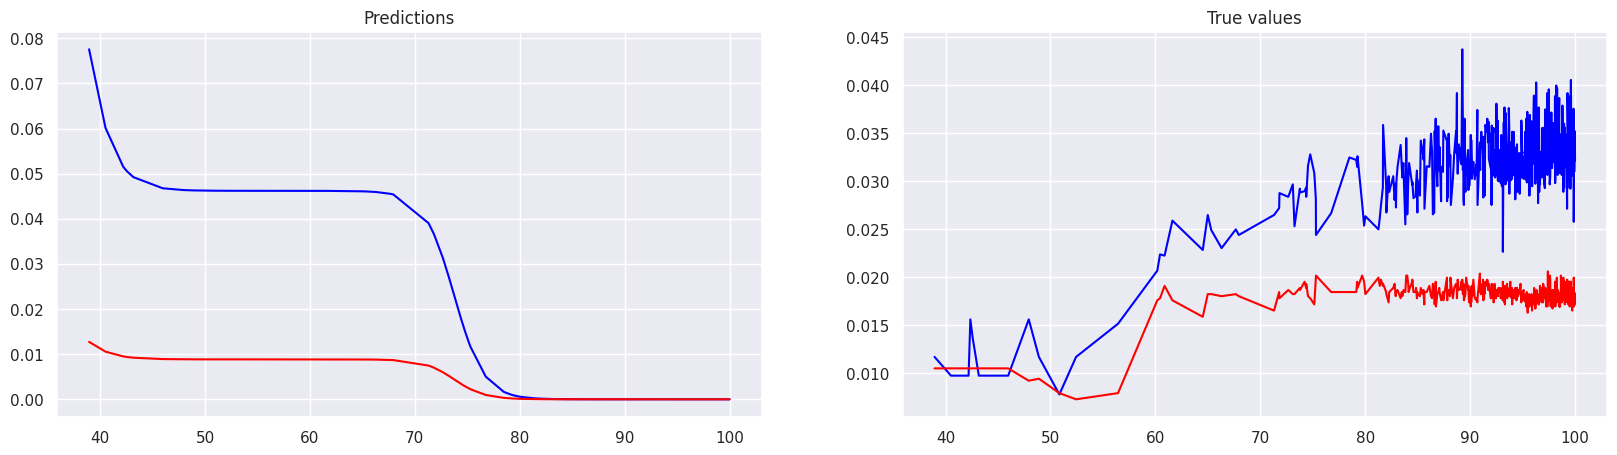

Epoch 401 - loss: 0.0013619280653074384
Epoch 402 - loss: 0.0013616960495710373
Epoch 403 - loss: 0.0013614657800644636
Epoch 404 - loss: 0.0013612365582957864
Epoch 405 - loss: 0.0013610095484182239
Epoch 406 - loss: 0.0013607837026938796
Epoch 407 - loss: 0.0013605596031993628
Epoch 408 - loss: 0.0013603369006887078
Epoch 409 - loss: 0.0013601155951619148
Epoch 410 - loss: 0.0013598958030343056
Epoch 411 - loss: 0.0013596774078905582
Epoch 412 - loss: 0.0013594606425613165
Epoch 413 - loss: 0.001359245041385293
Epoch 414 - loss: 0.001359031070023775
Epoch 415 - loss: 0.0013588184956461191
Epoch 416 - loss: 0.0013586072018370032
Epoch 417 - loss: 0.001358397421427071
Epoch 418 - loss: 0.0013581890380010009
Epoch 419 - loss: 0.0013579817023128271
Epoch 420 - loss: 0.0013577757636085153
Epoch 421 - loss: 0.0013575713383033872
Epoch 422 - loss: 0.0013573681935667992
Epoch 423 - loss: 0.0013571662129834294
Epoch 424 - loss: 0.001356965396553278
Epoch 425 - loss: 0.0013567660935223103
Epoc

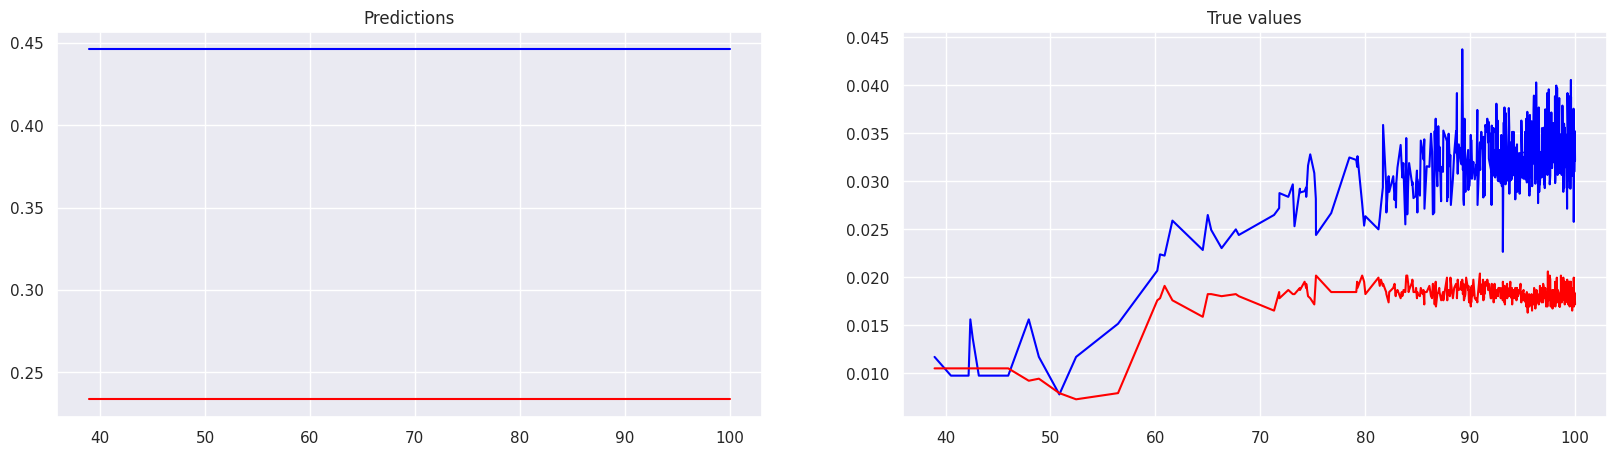

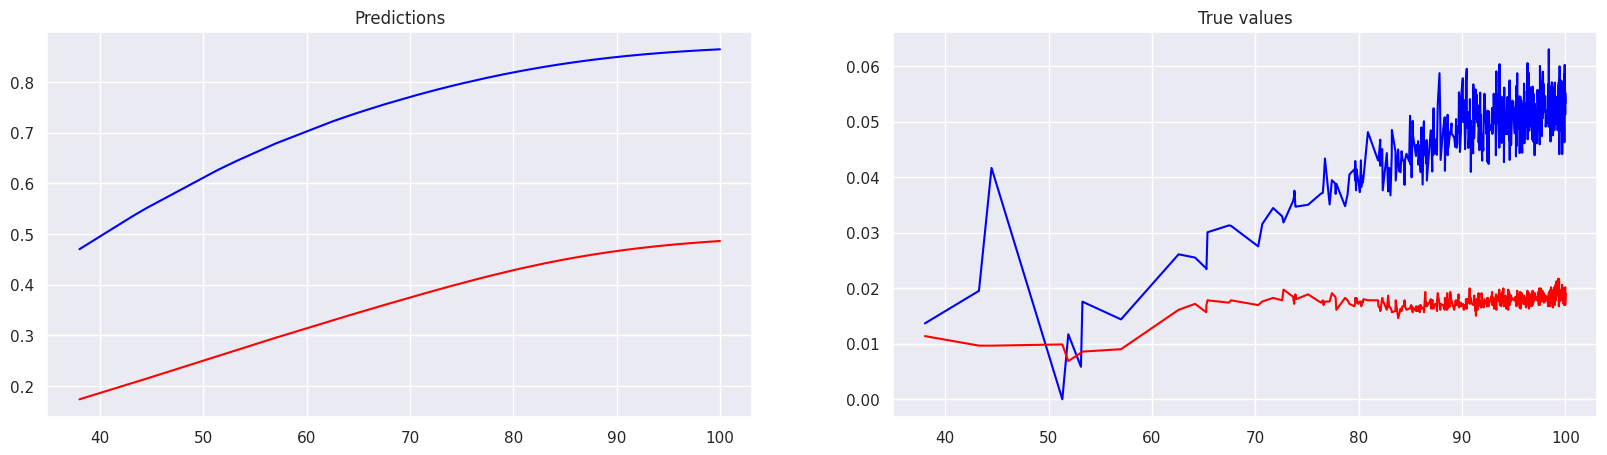

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0 - loss: 0.8373634219169617


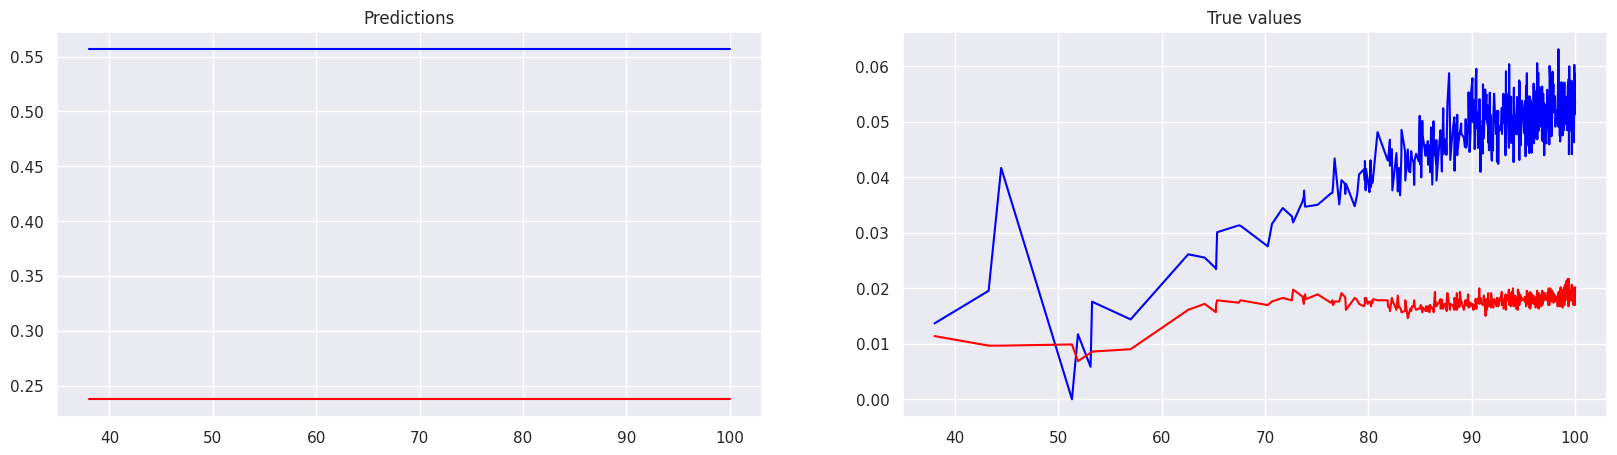

Epoch 1 - loss: 0.30676642060279846
Epoch 2 - loss: 0.015265099704265594
Epoch 3 - loss: 0.011676444672048092
Epoch 4 - loss: 0.011498913168907166
Epoch 5 - loss: 0.011251093819737434
Epoch 6 - loss: 0.01093105785548687
Epoch 7 - loss: 0.010582483373582363
Epoch 8 - loss: 0.01022813469171524
Epoch 9 - loss: 0.009879348799586296
Epoch 10 - loss: 0.009541903622448444
Epoch 11 - loss: 0.009218748658895493
Epoch 12 - loss: 0.008911294862627983
Epoch 13 - loss: 0.008620081469416618
Epoch 14 - loss: 0.008345125243067741
Epoch 15 - loss: 0.008086126297712326
Epoch 16 - loss: 0.00784258171916008
Epoch 17 - loss: 0.0076138610020279884
Epoch 18 - loss: 0.007399274501949549
Epoch 19 - loss: 0.007198076229542494
Epoch 20 - loss: 0.007009513210505247
Epoch 21 - loss: 0.006832827348262072
Epoch 22 - loss: 0.006667277310043573
Epoch 23 - loss: 0.006512136664241552
Epoch 24 - loss: 0.006366712506860495
Epoch 25 - loss: 0.006230336148291826
Epoch 26 - loss: 0.006102374754846096
Epoch 27 - loss: 0.00598

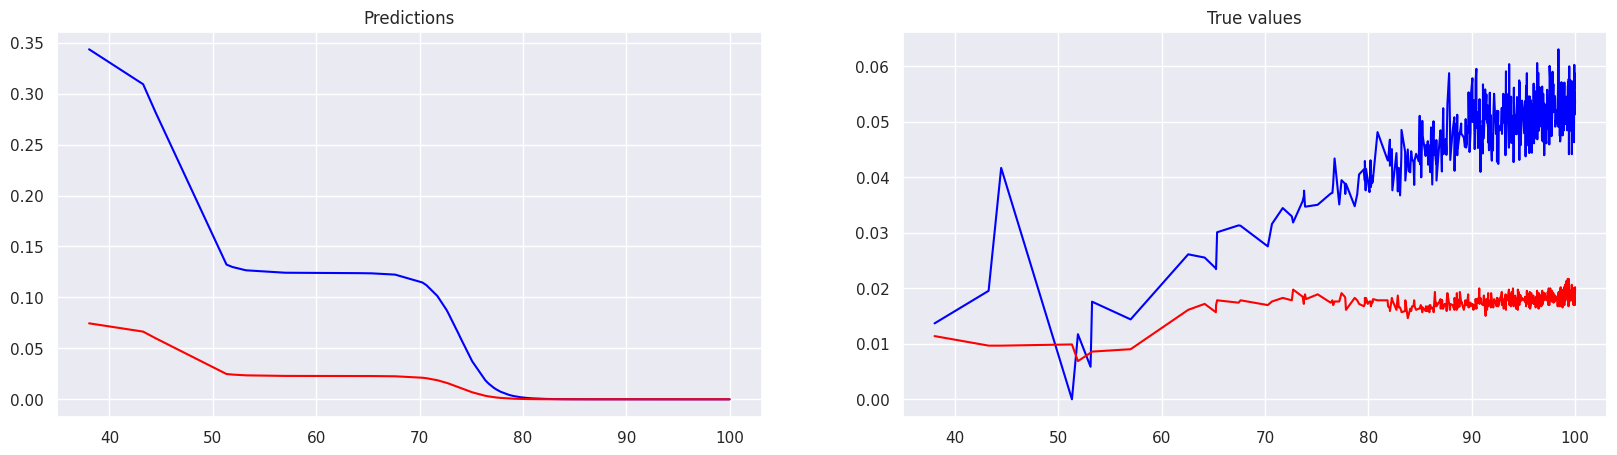

Epoch 101 - loss: 0.003484766697511077
Epoch 102 - loss: 0.003473974298685789
Epoch 103 - loss: 0.003463341388851404
Epoch 104 - loss: 0.003452862845733762
Epoch 105 - loss: 0.003442534478381276
Epoch 106 - loss: 0.0034323527943342924
Epoch 107 - loss: 0.0034223145339637995
Epoch 108 - loss: 0.003412417136132717
Epoch 109 - loss: 0.0034026564098894596
Epoch 110 - loss: 0.0033930290956050158
Epoch 111 - loss: 0.0033835330978035927
Epoch 112 - loss: 0.0033741649240255356
Epoch 113 - loss: 0.0033649238757789135
Epoch 114 - loss: 0.0033558050636202097
Epoch 115 - loss: 0.003346807789057493
Epoch 116 - loss: 0.0033379304222762585
Epoch 117 - loss: 0.0033291701693087816
Epoch 118 - loss: 0.0033205258660018444
Epoch 119 - loss: 0.003311994718387723
Epoch 120 - loss: 0.0033035764936357737
Epoch 121 - loss: 0.00329526886343956
Epoch 122 - loss: 0.0032870706636458635
Epoch 123 - loss: 0.003278980730101466
Epoch 124 - loss: 0.0032709978986531496
Epoch 125 - loss: 0.0032631217036396265
Epoch 126 -

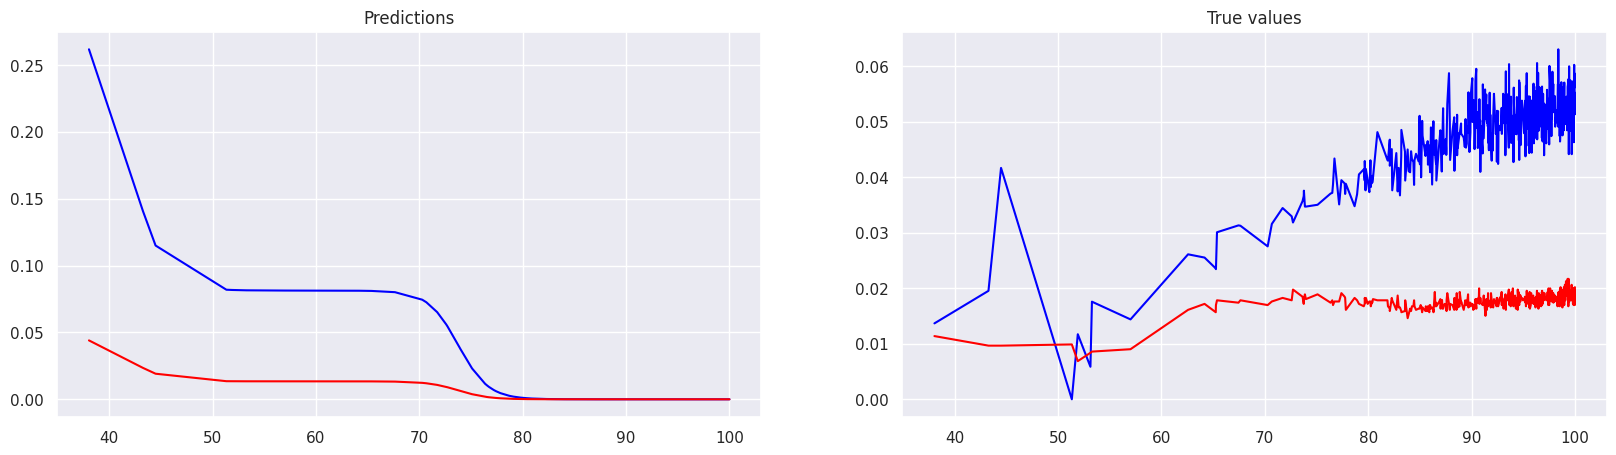

Epoch 201 - loss: 0.002915569581091404
Epoch 202 - loss: 0.0029132836498320103
Epoch 203 - loss: 0.0029110300820320845
Epoch 204 - loss: 0.0029088067822158337
Epoch 205 - loss: 0.0029066139832139015
Epoch 206 - loss: 0.0029044512193650007
Epoch 207 - loss: 0.0029023170936852694
Epoch 208 - loss: 0.002900210674852133
Epoch 209 - loss: 0.0028981321956962347
Epoch 210 - loss: 0.002896080492064357
Epoch 211 - loss: 0.002894054865464568
Epoch 212 - loss: 0.0028920546174049377
Epoch 213 - loss: 0.002890078816562891
Epoch 214 - loss: 0.0028881283942610025
Epoch 215 - loss: 0.002886201022192836
Epoch 216 - loss: 0.002884296700358391
Epoch 217 - loss: 0.002882415661588311
Epoch 218 - loss: 0.0028805562760680914
Epoch 219 - loss: 0.002878718078136444
Epoch 220 - loss: 0.0028769017662853003
Epoch 221 - loss: 0.0028751054778695107
Epoch 222 - loss: 0.002873329445719719
Epoch 223 - loss: 0.0028715727385133505
Epoch 224 - loss: 0.002869835589081049
Epoch 225 - loss: 0.0028681172989308834
Epoch 226 -

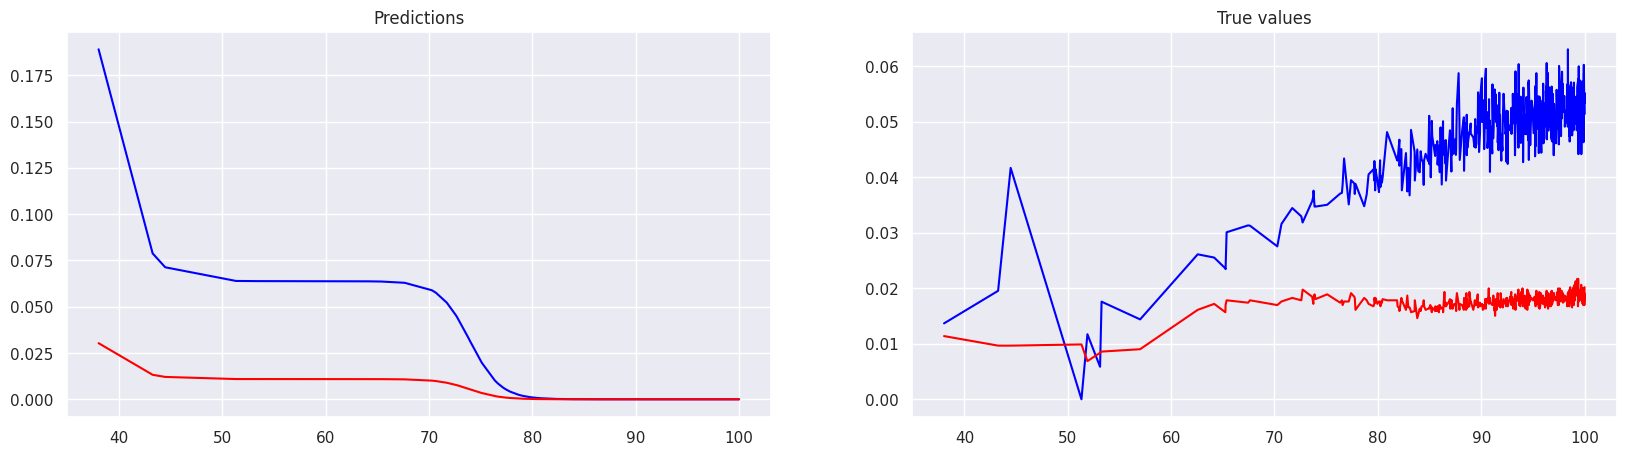

Epoch 301 - loss: 0.0027715684846043587
Epoch 302 - loss: 0.0027705933898687363
Epoch 303 - loss: 0.002769624115899205
Epoch 304 - loss: 0.002768660895526409
Epoch 305 - loss: 0.0027677039615809917
Epoch 306 - loss: 0.002766753314062953
Epoch 307 - loss: 0.0027658084873110056
Epoch 308 - loss: 0.0027648694813251495
Epoch 309 - loss: 0.002763936761766672
Epoch 310 - loss: 0.0027630103286355734
Epoch 311 - loss: 0.0027620901819318533
Epoch 312 - loss: 0.0027611758559942245
Epoch 313 - loss: 0.0027602678164839745
Epoch 314 - loss: 0.0027593658305704594
Epoch 315 - loss: 0.0027584705967456102
Epoch 316 - loss: 0.002757580950856209
Epoch 317 - loss: 0.002756697591394186
Epoch 318 - loss: 0.0027558207511901855
Epoch 319 - loss: 0.00275494996458292
Epoch 320 - loss: 0.0027540859300643206
Epoch 321 - loss: 0.0027532281819730997
Epoch 322 - loss: 0.00275237625464797
Epoch 323 - loss: 0.0027515313122421503
Epoch 324 - loss: 0.0027506924234330654
Epoch 325 - loss: 0.0027498602867126465
Epoch 326 

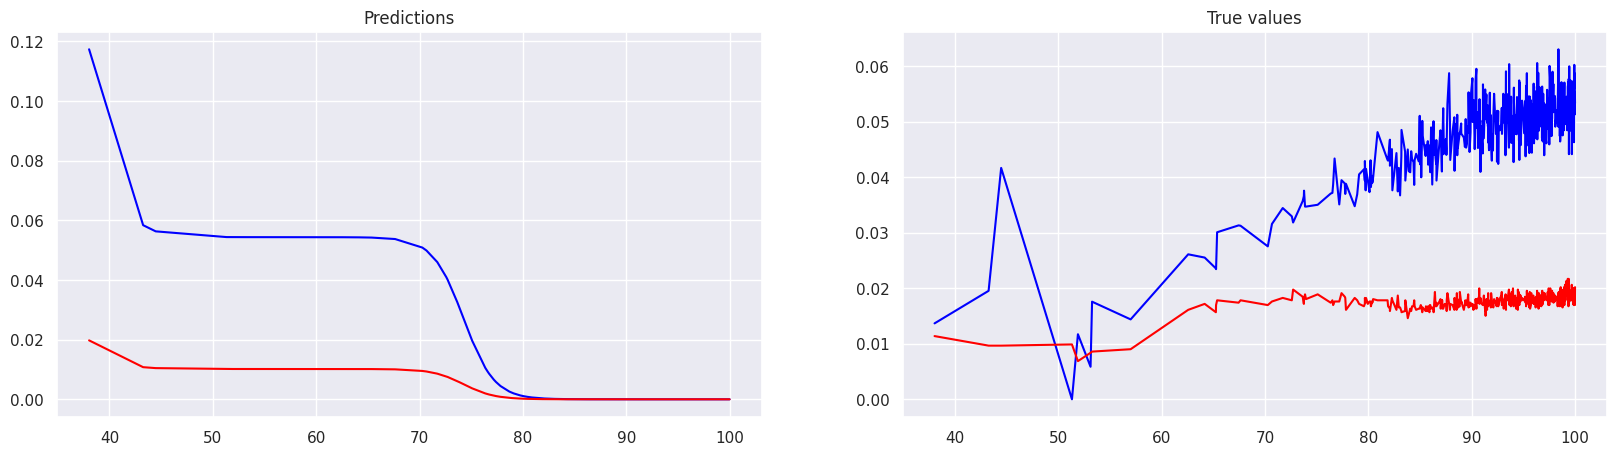

Epoch 401 - loss: 0.002705029910430312
Epoch 402 - loss: 0.0027046469040215015
Epoch 403 - loss: 0.0027042687870562077
Epoch 404 - loss: 0.002703893929719925
Epoch 405 - loss: 0.002703523263335228
Epoch 406 - loss: 0.002703156089410186
Epoch 407 - loss: 0.0027027931064367294
Epoch 408 - loss: 0.002702433383092284
Epoch 409 - loss: 0.002702077617868781
Epoch 410 - loss: 0.002701725345104933
Epoch 411 - loss: 0.0027013765648007393
Epoch 412 - loss: 0.0027010315097868443
Epoch 413 - loss: 0.002700689248740673
Epoch 414 - loss: 0.002700351644307375
Epoch 415 - loss: 0.0027000161353498697
Epoch 416 - loss: 0.002699684351682663
Epoch 417 - loss: 0.0026993558276444674
Epoch 418 - loss: 0.002699030563235283
Epoch 419 - loss: 0.0026987080927938223
Epoch 420 - loss: 0.00269838934764266
Epoch 421 - loss: 0.002698073163628578
Epoch 422 - loss: 0.0026977600064128637
Epoch 423 - loss: 0.0026974498759955168
Epoch 424 - loss: 0.0026971427723765373
Epoch 425 - loss: 0.0026968384627252817
Epoch 426 - lo

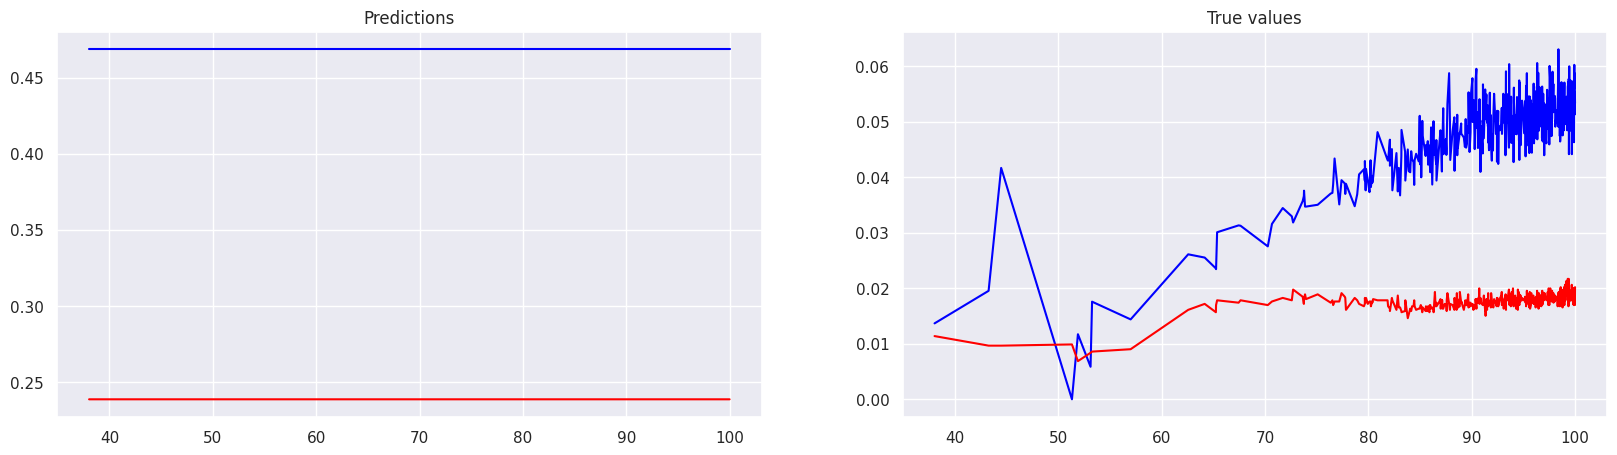

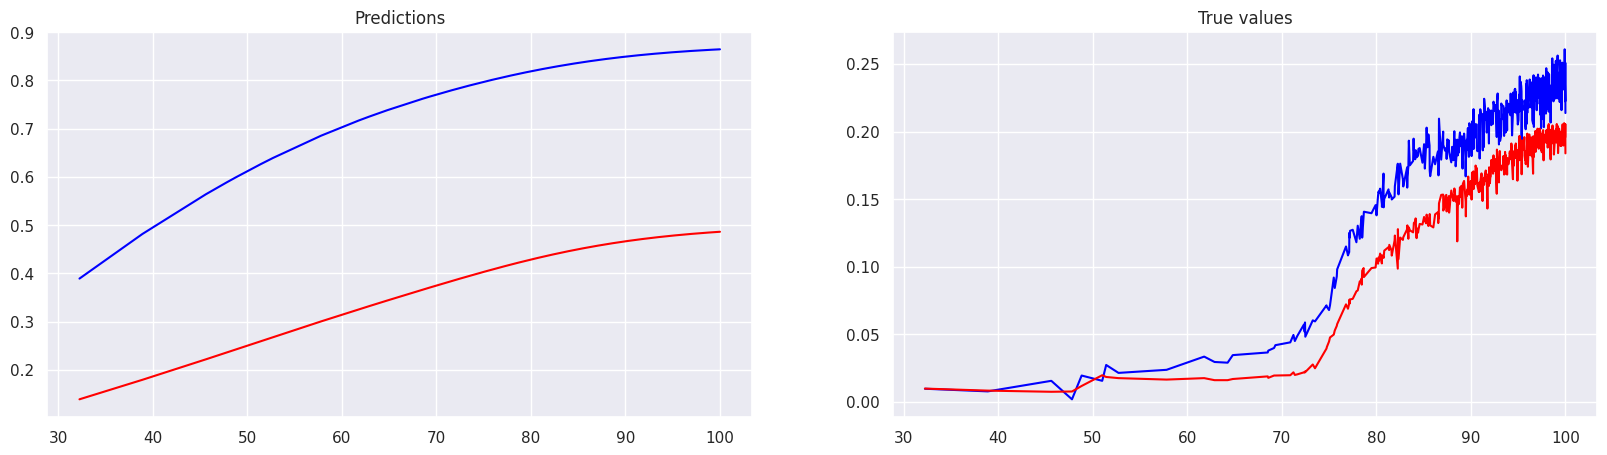

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0 - loss: 0.5100666284561157


In [8]:
for sweep, sweep_id, unique_col in zip(SWEEPS, SWEEP_IDS, UNIQUE_COLS): 
    fit_sweep(sweep, unique_col, num_patterns=3, max_time=100.0, log=True, sweep=sweep_id, num_epochs=500)

In [5]:
api = wandb.Api()
runs = api.runs(f"jqhoogland/fit-toy-model")
[run for run in runs]

[<Run jqhoogland/fit-toy-model/qc4itmz1 (running)>,
 <Run jqhoogland/fit-toy-model/0v1thdzj (finished)>,
 <Run jqhoogland/fit-toy-model/1gthqqg5 (finished)>,
 <Run jqhoogland/fit-toy-model/5s56iliv (crashed)>]

In [26]:
mw_fit_run_id = "1gthqq5"
run = runs[0]
df = run.history()

col = "d_model"
unique_vals = df.loc[:, col].unique()
unique_vals

array([  1,   2,   3,   4,   5,   6,   8,   9,  11,  14,  17,  20,  25,
        30,  37,  44,  54,  65,  79,  95, 115, 140, 169, 205, 248, 300])

In [47]:
D_MODEL = 115

model_entry = df.loc[df[col] == D_MODEL, :].iloc[0, :]
model_entry

pattern_0/onset                   3307.669922
_step                                      20
modulus                                   113
log                                      True
pattern_1/speed                       0.00761
d_vocab                                   114
num_training_steps                     100000
weight_decay                              0.3
_runtime                             2.410218
sweep                                l1b2mmci
pattern_1/onset                   4938.347168
lr                                      0.001
seed                                        0
pattern_1/generalization             0.701577
pattern_2/generalization             6.939834
num_layers                                  1
log_interval                               10
pattern_1/strength                     0.9862
pattern_0/strength                   0.077263
pattern_0/speed                      0.004219
d_model                                   115
pattern_2/strength                

In [50]:
def df_row_to_toy_model(row):
    model = PatternLearningModel(max_time=100.)

    for i, pattern in enumerate(model.patterns):
        pattern.onset.data = torch.tensor(row[f"pattern_{i}/onset"])
        pattern.speed.data = torch.tensor(row[f"pattern_{i}/speed"])
        pattern.strength.data = torch.tensor(row[f"pattern_{i}/strength"])
        pattern.generalization.data = torch.tensor(row[f"pattern_{i}/generalization"])

    return model

model = df_row_to_toy_model(model_entry)
model.rescale(100)
model


PatternLearningModel({'pattern_0/strength': tensor(0.0773, dtype=torch.float64), 'pattern_0/speed': tensor(0.0042, dtype=torch.float64), 'pattern_0/onset': tensor(3307.6699, dtype=torch.float64), 'pattern_0/generalization': tensor(0.0144, dtype=torch.float64), 'pattern_1/strength': tensor(0.9862, dtype=torch.float64), 'pattern_1/speed': tensor(0.0076, dtype=torch.float64), 'pattern_1/onset': tensor(4938.3472, dtype=torch.float64), 'pattern_1/generalization': tensor(0.7016, dtype=torch.float64), 'pattern_2/strength': tensor(0.9925, dtype=torch.float64), 'pattern_2/speed': tensor(0.0058, dtype=torch.float64), 'pattern_2/onset': tensor(7550.4229, dtype=torch.float64), 'pattern_2/generalization': tensor(6.9398, dtype=torch.float64)})

/Users/Jesse/Projects/pattern-learning/.venv/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Text(0.5, 1.0, 'Fit')

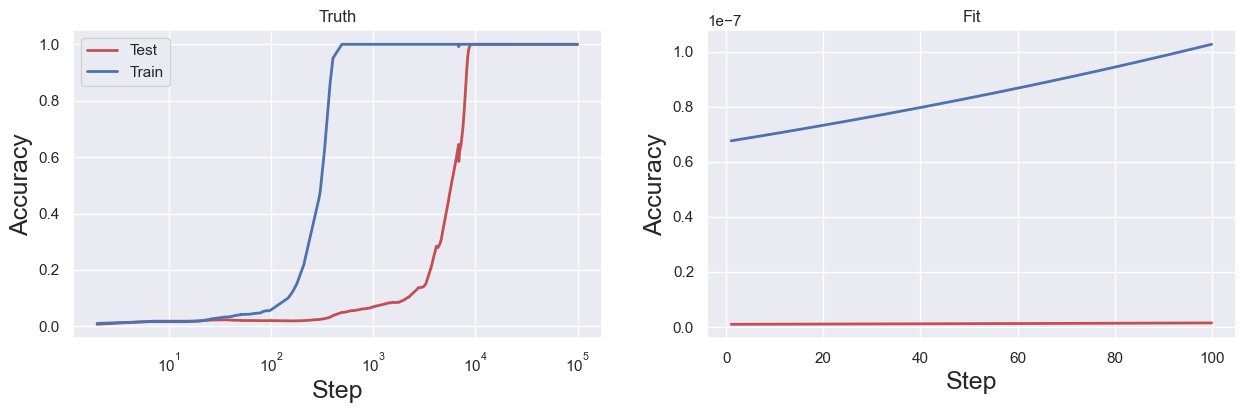

In [51]:
# Get corresponding original run
og_df = get_history(DM_SWEEP_ID, unique_cols="d_model")
run = og_df.loc[og_df.d_model==D_MODEL,:] #.plot(x="_step", y="test/acc")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

ax1.plot(run["_step"], run["test/acc"], label="Test", color=RED, linewidth=2)
ax1.plot(run["_step"], run["train/acc"], label="Train", color=BLUE, linewidth=2)
ax1.set_ylabel("Accuracy", fontsize=18)
ax1.set_xlabel("Step", fontsize=18)
ax1.set_xscale("log")
ax1.legend()
ax1.set_title("Truth")

min_step, max_step = og_df["_step"].min(), 10000 # run["_step"].max()

ts = np.linspace(min_step, max_step, 1000)
train_ys = [model(t).detach().numpy() for t in ts]
test_ys = [model.test(t).detach().numpy() for t in ts]
ax2.plot(ts, train_ys, label="Train", color=BLUE, linewidth=2)
ax2.plot(ts, test_ys, label="Test", color=RED, linewidth=2)
ax2.set_ylabel("Accuracy", fontsize=18)
ax2.set_xlabel("Step", fontsize=18)
ax2.set_title("Fit")

# Already in log scale
# train_ys, test_ys

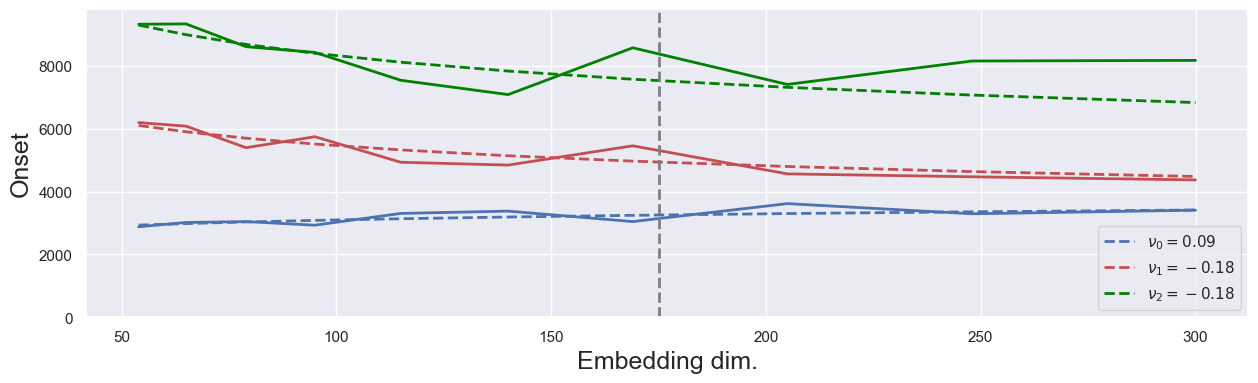

In [70]:
# Ignore any d_model < 50
df_cleaned = df.loc[df["d_model"] >= 50, :]
d_models = df_cleaned.loc[:, "d_model"].unique()

# Scaling analysis
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)

colors = [BLUE, RED, "green"]
y_max = 0

for i in range(3):
    slice = df_cleaned.loc[:, f"pattern_{i}/onset"]
    y_max = max(y_max, slice.max())
    ax.plot(d_models, slice, label=f"", color=colors[i], linewidth=2)

ax.set_xlabel("d_model", fontsize=18)
ax.set_ylabel("Onset", fontsize=18)


# Fit a power-law to the onsets 
from scipy.optimize import curve_fit

def power_law(x, a, b):
    return a * x**b

def fit_power_law(x, y):
    popt, pcov = curve_fit(power_law, x, y)
    return popt


CUTOFF = 175

# Fit power law to onset
for i in range(3):
    # Train up to a specific point
    df_to_fit = df_cleaned.loc[df_cleaned["d_model"] <= CUTOFF, :]
    d_models_to_fit = df_to_fit.loc[:, "d_model"].unique()

    onset_popt = fit_power_law(d_models_to_fit, df_to_fit.loc[:, f"pattern_{i}/onset"])
    exponent = round(onset_popt[1], 2)
    ax.plot(d_models, power_law(d_models, *onset_popt), label=f"$\\nu_{i} = {exponent}$", color=colors[i], linestyle="--", linewidth=2)

ax.vlines(CUTOFF, 0, y_max * 1.05, color="grey", linestyle="--", linewidth=2)
ax.set_xlabel("Embedding dim.", fontsize=18)
ax.set_ylim(0, y_max * 1.05)

ax.legend()

In [ ]:
# Let's see if we can fit 